In [1]:
import itertools
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

PROJECT_DIR = os.path.dirname(os.getcwd())
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from chord_recognition.cache import HDF5Cache
from chord_recognition.evaluate import evaluate_dataset, print_ds_compute_average_scores
from chord_recognition.models.deep_harmony import deep_harmony
from chord_recognition.dataset import make_batch_frame_log_spec_dataset, prepare_datasource
from chord_recognition.transformations import Rescale
from chord_recognition.train import Solver, data_processing

torch.manual_seed(2020)
RANDOM_STATE = 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

In [ ]:
# Exp. 6.4
# Rec_chroma v2
# 3-layers 32 ResCNN
# 3-layers 64 ResCNN

In [2]:
window_size = 8192
hop_length = 4410
seq_length = 100
#ds = prepare_datasource(('beatles', 'zweieck', 'queen', 'robbie_williams'))
ds = prepare_datasource(('beatles',))
cache = HDF5Cache(os.path.join(PROJECT_DIR, 'spectrogram_ann_cache.hdf5'))

dataset = make_batch_frame_log_spec_dataset(
    datasource=ds,
    window_size=window_size,
    hop_length=hop_length,
    seq_length=seq_length,
    cache=cache
)

In [3]:
# Split dataset into train/val
indices = np.arange(len(dataset))
idx_train, idx_val = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_STATE)

In [4]:
train_data = Subset(dataset, idx_train)

# Calculate TRAIN_MEAN, TRAIN_STD
X_train_temp = np.vstack([xi for xi,_ in train_data])
TRAIN_MEAN = X_train_temp.mean(axis=0).reshape(1, -1)
TRAIN_STD = X_train_temp.std(axis=0).reshape(1, -1)

del X_train_temp

In [5]:
val_data = Subset(dataset, idx_val)

transform = transforms.Compose([
    Rescale(TRAIN_MEAN, TRAIN_STD),
])

train_data.dataset.transform = transform
val_data.dataset.transform = transform

In [6]:
batch_size = 256

# Split dataset into train/val datasets
loader_train = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    collate_fn=lambda x: data_processing(x),
    num_workers=0)
loader_val = DataLoader(
    dataset=val_data,
    num_workers=0,
    collate_fn=lambda x: data_processing(x),
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

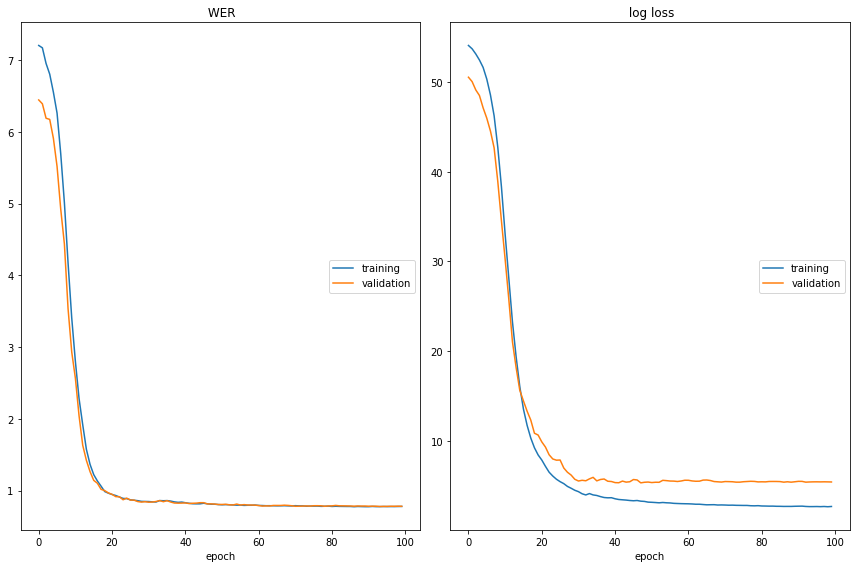

 WER
	training         	 (min:    0.775, max:    7.206, cur:    0.779)
	validation       	 (min:    0.778, max:    6.446, cur:    0.781)
 log loss
	training         	 (min:    2.639, max:   54.095, cur:    2.667)
	validation       	 (min:    5.304, max:   50.555, cur:    5.401)


In [7]:
model = deep_harmony(
    n_feats=105,
    n_rnn_layers=3,
    cnn_kwargs=dict(n_cnn_layers=3, block_depth=2, nonlinearity=nn.ReLU))

if torch.cuda.is_available():
    model.cuda()

learning_rate = 1e-3
epochs=100
weight_decay = 0
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(loader_train),
    epochs=epochs,
    anneal_strategy='linear',
)

solver = Solver(
    model=model,
    optimizer=optimizer,
    dataloaders=dataloaders,
    scheduler=scheduler,
    trained_model_name="deep_harmony_exp6_4.pth",
    epochs=epochs)
solver.train()

In [11]:
# Evaluate exp model

In [12]:
audio_processor = dataset.dataset.audio_processor
spec_dataset = dataset.dataset

model = deep_harmony(pretrained=True,
                    model_name="deep_harmony_exp6_4.pth",
                    n_feats=105,
                    n_rnn_layers=3,
                    cnn_kwargs=dict(n_cnn_layers=3, block_depth=2, nonlinearity=nn.ReLU))
model.eval()

evaluate_dataset(
    dataset=spec_dataset,
    model=model,
    save_ann=True)

Process: <01-A_Hard_Day_s_Night>
Process: <02-I_Should_Have_Known_Better>
Process: <03-If_I_Fell>
Process: <04-I_m_Happy_Just_To_Dance_With_You>
Process: <05-And_I_Love_Her>
Process: <06-Tell_Me_Why>
Process: <07-Can_t_Buy_Me_Love>
Process: <08-Any_Time_At_All>
Process: <09-I_ll_Cry_Instead>
Process: <10-Things_We_Said_Today>
Process: <11-When_I_Get_Home>
Process: <12-You_Can_t_Do_That>
Process: <13-I_ll_Be_Back>
Process: <01-Come_Together>
Process: <02-Something>
Process: <03-Maxwell_s_Silver_Hammer>
Process: <04-Oh_Darling>
Process: <05-Octopus_s_Garden>
Process: <06-I_Want_You_She_s_So_Heavy_>
Process: <07-Here_Comes_The_Sun>
Process: <08-Because>
Process: <09-You_Never_Give_Me_Your_Money>
Process: <10-Sun_King>
Process: <11-Mean_Mr_Mustard>
Process: <12-Polythene_Pam>
Process: <13-She_Came_In_Through_The_Bathroom_Window>
Process: <14-Golden_Slumbers>
Process: <15-Carry_That_Weight>
Process: <16-The_End>
Process: <17-Her_Majesty>
Process: <01-No_Reply>
Process: <02-I_m_A_Loser>
Proc

In [15]:
print_ds_compute_average_scores('beatles')

	thirds:        0.347
	thirds_inv:    0.335
	triads:        0.338
	triads_inv:    0.328
	tetrads:       0.317
	tetrads_inv:   0.310
	root:          0.365
	mirex:         0.353
	majmin:        0.360
	majmin_inv:    0.349
	sevenths:      0.342
	sevenths_inv:  0.334
	underseg:      0.425
	overseg:       0.893
	seg:           0.423
